In [ ]:
import jax.numpy as jnp
import jax.scipy as jsp
from random import randint as rn
from jax import random, grad, jit, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt

In [ ]:
def one_hot_encode(y, num_classes):
    return jnp.eye(num_classes)[y]

In [ ]:
# read mnist data
def read_mnist_images(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2051
        n_images = int.from_bytes(data[4:8], byteorder='big')
        n_rows = int.from_bytes(data[8:12], byteorder='big')
        n_cols = int.from_bytes(data[12:16], byteorder='big')
        images = jnp.frombuffer(data, dtype=jnp.uint8, offset=16)
        return images, n_images, n_rows, n_cols


def read_mnist_labels(filename):
    with open(filename, 'rb') as f:
        data = f.read()
        assert int.from_bytes(data[:4], byteorder='big') == 2049
        labels = jnp.frombuffer(data, dtype=jnp.uint8, offset=8)
        return labels


x, num_inputs, num_rows, num_cols = read_mnist_images('../mnist/train-images.idx3-ubyte')
x = x / 255.
x = x.reshape((-1, 1, 28, 28))
y = one_hot_encode(read_mnist_labels('../mnist/train-labels.idx1-ubyte'), 10)

In [ ]:
def init_dense_params(n_inputs, n_neurons):
    rng = random.PRNGKey(rn(0, 10000))
    variance = jnp.sqrt(6/(n_inputs + n_neurons))
    weights = random.normal(key=rng, shape=(n_neurons, n_inputs)) * variance # xavier initialization from tensorflow
    biases = jnp.zeros((n_neurons, ))
    return weights, biases


def dense_forward(weights, biases, inputs):
    return jnp.dot(weights, inputs) + biases


In [ ]:
def init_conv_params(num_kernels, num_channels, kernel_size):
    rng = random.PRNGKey(rn(0, 10000))
    variance = jnp.sqrt(6/(kernel_size*kernel_size*num_channels))
    weights = random.normal(key=rng, shape=(num_kernels, num_channels, kernel_size, kernel_size)) * variance
    biases = jnp.zeros((num_kernels,))
    return weights, biases


def conv_forward_single_kernel(kernel, bias, image, mode='valid'):
    def convolve_single_channel(channel_kernel, bias, image_channel):
        return jsp.signal.correlate(image_channel, channel_kernel, mode=mode) + bias
    multichannel_convolve = vmap(convolve_single_channel, in_axes=(0, None, 0))
    return jnp.sum(multichannel_convolve(kernel, bias, image), axis=0)


def conv_forward_multi_kernel(kernels, biases, image, mode='valid'):
    return jnp.stack([conv_forward_single_kernel(kernel, bias, image, mode=mode) for kernel, bias in zip(kernels, biases)], axis=0)


In [ ]:
def pool2d(input_channel, pool_size, stride):
    p_h = pool_size
    p_w = pool_size
    Y = jnp.zeros(((input_channel.shape[0] - p_h)//stride + 1, (input_channel.shape[1] - p_w)//stride + 1))
    for i in range(0, Y.shape[0]):
        for j in range(0, Y.shape[1]):
            max_of_window = input_channel[stride*i: stride*i + p_h, stride*j: stride*j + p_w].max()
            Y = Y.at[i, j].set(max_of_window)
    return Y

def pool2d_channeled(image, pool_size, stride):
    channeled_pool = vmap(pool2d, in_axes=(0, None, None))
    return channeled_pool(image, pool_size, stride)

In [ ]:
def flatten(inputs):
    return inputs.reshape((inputs.shape[0] * inputs.shape[1] * inputs.shape[2]))

In [ ]:
def relu(inputs):
    return jnp.maximum(0, inputs)

In [ ]:
def softmax_cross_corr_loss(inputs):
    return inputs - logsumexp(inputs)


In [ ]:
def predict(params, image):
    activation = image
    params_conv = params[0]
    params_dense = params[1]
    for f, b in params_conv:
        activation = conv_forward_multi_kernel(f, b, activation, mode='same')
        activation = relu(activation)
        activation = pool2d_channeled(activation, 2, 2)
    activation = flatten(activation)
    for w, b in params_dense[:-1]:
        activation = dense_forward(w, b, activation)
        activation = relu(activation)
    last_w, last_b = params_dense[-1]
    activation = dense_forward(last_w, last_b, activation)
    return softmax_cross_corr_loss(activation)


def batched_predict(params, images):
    b_predict = vmap(predict, in_axes=(None, 0))
    return b_predict(params, images)


def loss(params, x, y):
    preds = batched_predict(params, x)
    return -jnp.mean(preds*y)

@jit
def optimize(params, x, y, learning_rate=1):
    gradients = grad(loss)(params, x, y)
    return [[(w - learning_rate*dw, b - learning_rate*db) for (dw, db), (w, b) in zip(gradients[i], params[i])] for i in range(len(gradients))]

In [ ]:
def accuracy(params, images, targets):
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
  return jnp.mean(predicted_class == target_class)

In [ ]:
def train(params, x, y, epochs, batch_size):
    for i in range(epochs):
        for j in range(0, len(x), batch_size):
            x_batch = x[j:j+batch_size]
            y_batch = y[j:j+batch_size]
            params = optimize(params, x_batch, y_batch, learning_rate=0.1)

        train_acc = accuracy(params, x, y)
        train_loss = loss(params, x, y)
        print(f'epoch: {i}, ' + f'acc: {train_acc:.3f}, ' + f'loss: {train_loss:.3f}')
    return params


# Fashion MNIST model - CNN Architecture

In [ ]:
params = [
    [
        init_conv_params(3, 1, 3),
        init_conv_params(2, 3, 3),
        init_conv_params(2, 2, 3)
    ],
    [
        init_dense_params(18, 10),
        init_dense_params(10, 10),
        init_dense_params(10, 10)
    ]
]

In [ ]:
x_fashion, num_inputs_fashion, n_rows, n_cols = read_mnist_images('../fashion_mnist/train-images-idx3-ubyte')
x_fashion = x_fashion.reshape((-1, 1, n_rows, n_cols)) / 255.
y_fashion = one_hot_encode(read_mnist_labels('../fashion_mnist/train-labels-idx1-ubyte'), 10)

In [ ]:
epochs = 30
batch_size = 10

params = train(params, x_fashion, y_fashion, epochs, batch_size)


epoch: 0, acc: 0.690, loss: 0.084
epoch: 1, acc: 0.736, loss: 0.072
epoch: 2, acc: 0.759, loss: 0.065
epoch: 3, acc: 0.779, loss: 0.060
epoch: 4, acc: 0.788, loss: 0.057
epoch: 5, acc: 0.794, loss: 0.056
epoch: 6, acc: 0.794, loss: 0.056
epoch: 7, acc: 0.797, loss: 0.056
epoch: 8, acc: 0.800, loss: 0.055
epoch: 9, acc: 0.802, loss: 0.055
epoch: 10, acc: 0.805, loss: 0.055
epoch: 11, acc: 0.807, loss: 0.054
epoch: 12, acc: 0.808, loss: 0.053
epoch: 13, acc: 0.808, loss: 0.054
epoch: 14, acc: 0.807, loss: 0.054
epoch: 15, acc: 0.809, loss: 0.053
epoch: 16, acc: 0.810, loss: 0.053
epoch: 17, acc: 0.811, loss: 0.052
epoch: 18, acc: 0.808, loss: 0.054
epoch: 19, acc: 0.809, loss: 0.054
epoch: 20, acc: 0.813, loss: 0.052
epoch: 21, acc: 0.814, loss: 0.051
epoch: 22, acc: 0.816, loss: 0.051
epoch: 23, acc: 0.815, loss: 0.051
epoch: 24, acc: 0.816, loss: 0.051
epoch: 25, acc: 0.817, loss: 0.051
epoch: 26, acc: 0.818, loss: 0.050
epoch: 27, acc: 0.818, loss: 0.050
epoch: 28, acc: 0.820, loss: 0

In [23]:
fashion_interpretation_dict = {
    0: 'T-shirt/top',
    1:'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

Network Prediction: 8 - Bag
Correct Prediction: 8 - Bag


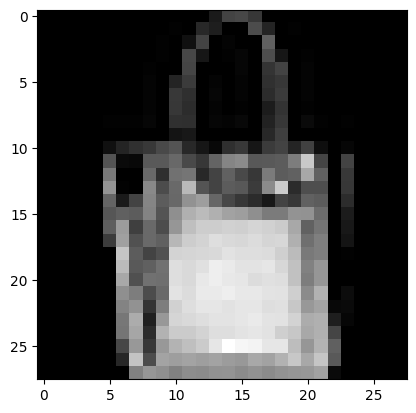

In [35]:
# Specific Sample Testing
test_sample_num = 3302
x_test_fashion, num_inputs_test_fashion, n_rows, n_cols = read_mnist_images('../fashion_mnist/t10k-images-idx3-ubyte')
x_test_fashion = x_test_fashion.reshape(-1, 1, n_rows, n_cols) / 255.
y_test_fashion = one_hot_encode(read_mnist_labels('../fashion_mnist/t10k-labels-idx1-ubyte'), 10)
predicted_class = int(jnp.argmax(predict(params, x_test_fashion[test_sample_num])))
print(f'Network Prediction: {predicted_class} - {fashion_interpretation_dict[predicted_class]}')
print(f'Correct Prediction: {jnp.argmax(y_test_fashion[test_sample_num])} - {fashion_interpretation_dict[int(jnp.argmax(y_test_fashion[test_sample_num]))]}')
plt.imshow(x_test_fashion[test_sample_num].reshape((28, 28)), cmap='gray')


In [29]:
# General Evaluation
print(f'Accuracy on eval dataset: {accuracy(params, x_test_fashion, y_test_fashion)}%')


Accuracy on eval dataset: 0.809499979019165%
